## Phantom Simulation

**Goal for the week (11 - 17 Jan.):** \
• Use the Shepp-Logan phantom package \
• Do a 2D Fourier transform of the array \
• Bunus point: add an image shift

In [2]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
import ipywidgets as widgets
from PIL import Image

### 0. Functions

In [3]:
def shift_2d_array(arr_in, rl_shift, ud_shift):
#input: arr_in (input array), rl_shift (shift to right(+ve)/left(-ve) by how many pixels), ud_shift (shift upwards(+ve)/downwards(-ve) by how many pixels)
    rows, cols = arr_in.shape #get array size
    
    shifted_array_vertical = np.roll(arr_in, ud_shift, axis=0) #vertical shift
    
    arr_out = np.roll(shifted_array_vertical, rl_shift, axis=1) #horizontal shift
    
    return np.array(arr_out, dtype = float)

In [4]:
# def slider_show(images, idx):
#     images = np.abs(images)
#     _, ax = plt.subplots(1,1)
#     plt.imshow(images[...,int(idx)], cmap="gray")
#     plt.axis('off')
#     interact(slider_show, idx = widgets.FloatSlider(value=0,
#                                                min=0,
#                                                max=images.shape[-1]-1,
#                                                step=1))

In [5]:
# image_list = [np.random.random((10, 10)) for _ in range(5)]

# # Determine the shape of the 3D array based on the size of the 2D images
# height, width = image_list[0].shape
# num_images = len(image_list)

# # Create a 3D NumPy array
# array_3d = np.zeros((height, width, num_images))

# # Populate the 3D array with the 2D images
# for i, img in enumerate(image_list):
#     array_3d[:, :, i] = img

### 1. Phantom Image Fourier Transform

In [6]:
#create 500*500 phantom image
phantom_img = sp.shepp_logan([256,256], float)

#Apply a 2D transformation on the image
phantom_kspace = np.fft.fftshift(np.fft.fft2(phantom_img))
magnitude_spectrum = np.log(np.abs(phantom_kspace) + 1) # Compute the magnitude spectrum (log-scaled for better visualization)
phase_spectrum = np.angle(phantom_kspace)

<function matplotlib.pyplot.show(close=None, block=None)>

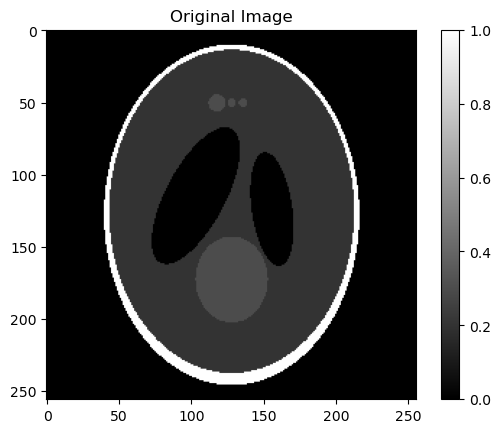

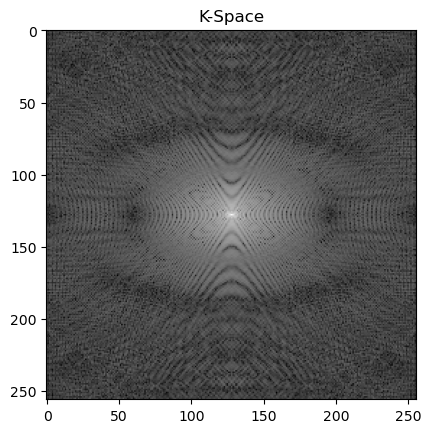

In [7]:
#plot phatom image in image space
plt.figure(1)
plt.imshow(phantom_img, cmap='gray')
plt.title('Original Image')
colorbar = plt.colorbar()

#plot magnitude spectrum in k-space
plt.figure(2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('K-Space')

plt.show

### 2. Phantom Image Spacial Shift and Effect in K-Space

In [8]:
#shift phantom image (simulate motion)
shifted_phantom_img = shift_2d_array(phantom_img,0,10)

<function matplotlib.pyplot.show(close=None, block=None)>

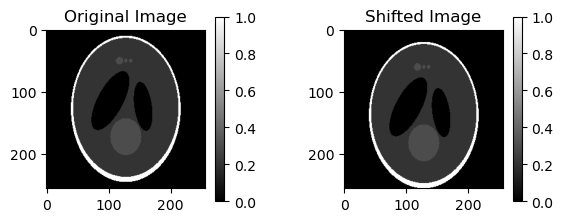

In [9]:
plt.subplot(121)
plt.imshow(phantom_img, cmap='gray')
plt.title('Original Image')
colorbar = plt.colorbar(shrink=0.5)

#plot magnitude spectrum in k-space
plt.subplot(122)
plt.imshow(shifted_phantom_img, cmap='gray')
plt.title('Shifted Image')
colorbar = plt.colorbar(shrink=0.5)

plt.subplots_adjust(wspace=0.5)

plt.show

In [10]:
#Apply a 2D transformation on the shifted image
shifted_phantom_kspace = np.fft.fftshift(np.fft.fft2(shifted_phantom_img))
shifted_magnitude_spectrum = np.log(np.abs(shifted_phantom_kspace) + 1)
shifted_phase_spectrum = np.angle(shifted_phantom_kspace)

phase_product = shifted_phantom_kspace * np.conj(phantom_kspace)
phase_difference = np.angle(phase_product)

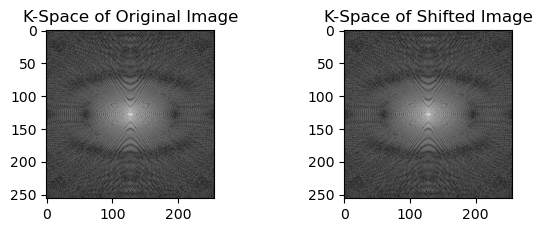

In [11]:
plt.subplot(221)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('K-Space of Original Image')


#plot magnitude spectrum in k-space
plt.subplot(222)
plt.imshow(shifted_magnitude_spectrum, cmap='gray')
plt.title('K-Space of Shifted Image')

plt.subplots_adjust(wspace=0.5)

In [12]:
print(shifted_magnitude_spectrum)

[[2.34180581 0.58260023 2.00854981 ... 1.74642813 2.00854981 0.58260023]
 [2.60509834 1.10032945 2.47015033 ... 2.1611895  2.49899864 1.10652169]
 [2.63327574 2.06361591 2.38441505 ... 2.9054917  2.34520826 1.99242439]
 ...
 [2.28668055 0.75288601 1.80218013 ... 1.96488922 1.87851897 0.91321483]
 [2.63327574 1.99242439 2.34520826 ... 2.89220372 2.38441505 2.06361591]
 [2.60509834 1.10652169 2.49899864 ... 2.06051793 2.47015033 1.10032945]]


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.44089210e-16  2.22044605e-16  0.00000000e+00 ...  0.00000000e+00
  -4.44089210e-16  2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00  4.44089210e-16 ...  0.00000000e+00
   0.00000000e+00  2.22044605e-16]
 ...
 [ 4.44089210e-16  4.44089210e-16  4.44089210e-16 ...  0.00000000e+00
  -2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00 -2.22044605e-16  0.00000000e+00 ...  0.00000000e+00
   4.44089210e-16  4.44089210e-16]
 [-4.44089210e-16  8.88178420e-16  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -6.66133815e-16]]


Text(0.5, 1.0, 'Magnitude Difference')

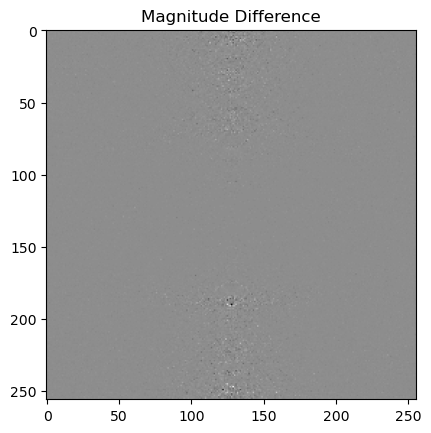

In [13]:
magnitude_difference = shifted_magnitude_spectrum - magnitude_spectrum
print(magnitude_difference)

plt.figure()
plt.imshow(magnitude_difference, cmap='gray')
plt.title('Magnitude Difference')

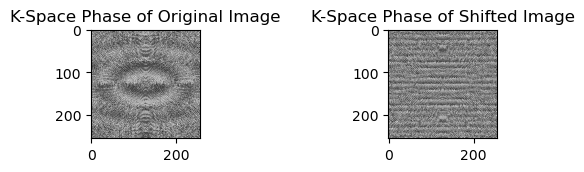

In [14]:
plt.subplot(321)
plt.imshow(phase_spectrum, cmap='gray')
plt.title('K-Space Phase of Original Image')


#plot magnitude spectrum in k-space
plt.subplot(322)
plt.imshow(shifted_phase_spectrum, cmap='gray')
plt.title('K-Space Phase of Shifted Image')


plt.subplots_adjust(wspace=0.5)

Text(0.5, 1.0, 'Phase Difference between Shifted and Original Image')

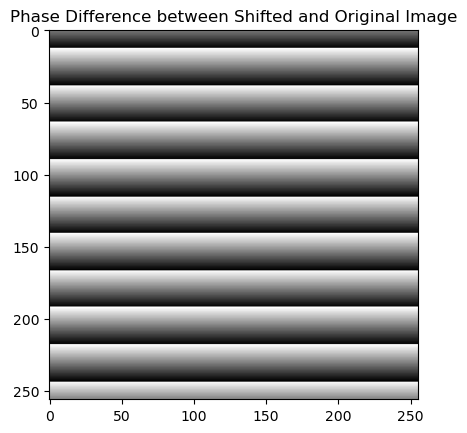

In [15]:
plt.figure()
plt.imshow(phase_difference, cmap='gray')
plt.title('Phase Difference between Shifted and Original Image')

Absolute value of k-space should be exactly the same for the original and shifted image\
Only the phase of k-space should look different - difference between the 2 images should show a phase ramp

### 3. Periodic Motion

3D stack of images, additional time scale, 20 frames of images in 1 cardiac cycle, sample sequencially in k-space, then do inverse fourier transform

Displacement: sinusoidal approximation of motion

/var/folders/q0/lwpc1mps2dx1drxs08g4mz2h0000gn/T/ipykernel_3066/3723762277.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  kspace_stack[:,:,i] = np.fft.fftshift(np.fft.fft2(img_stack[:,:,i]))


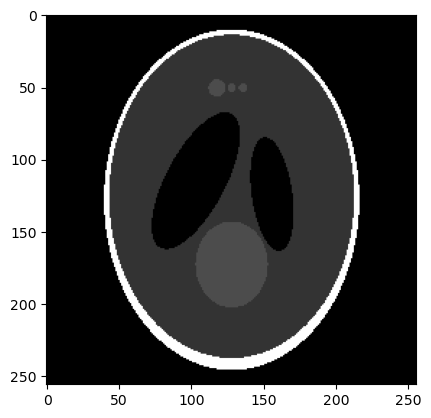

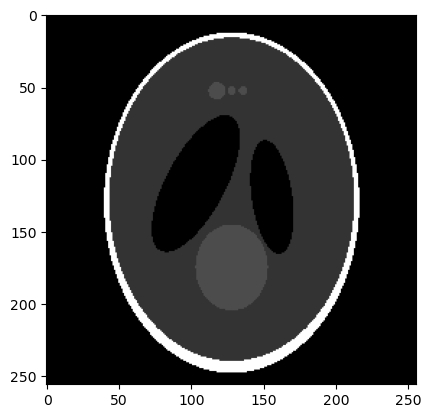

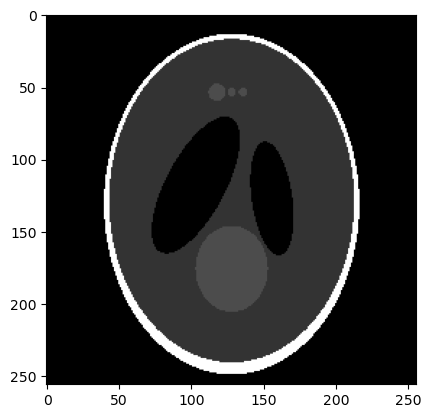

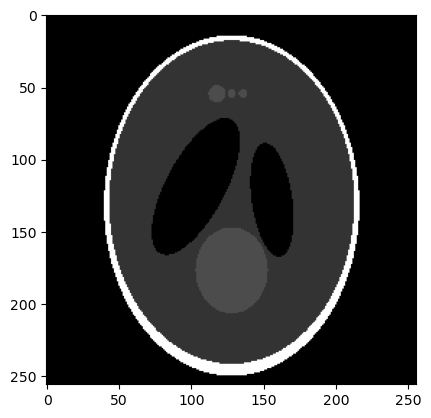

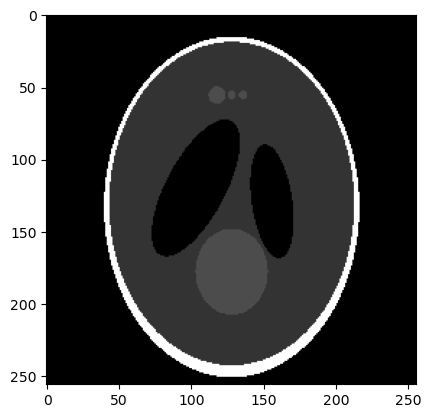

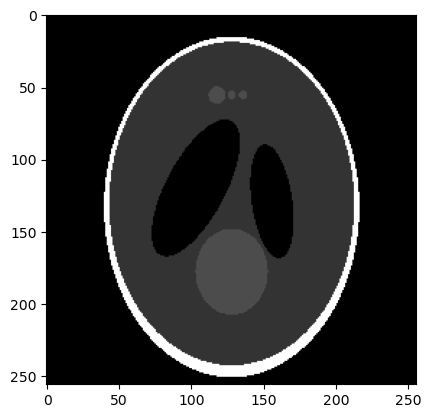

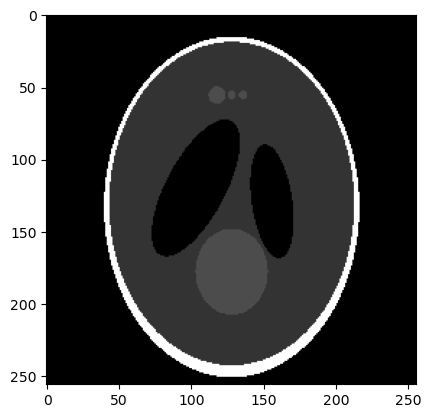

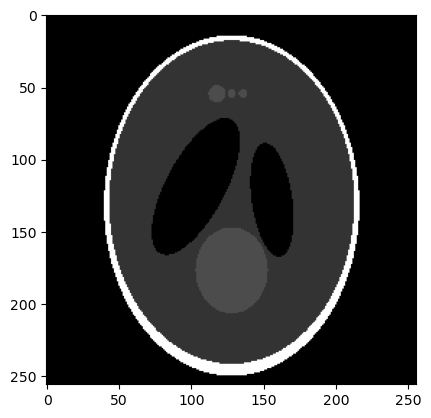

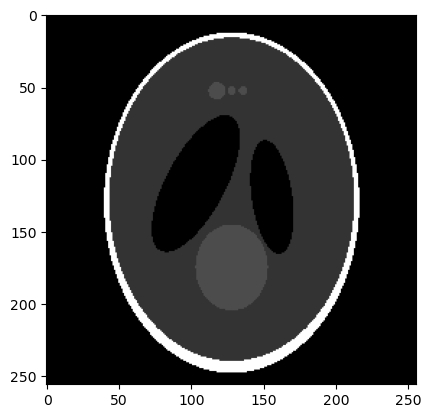

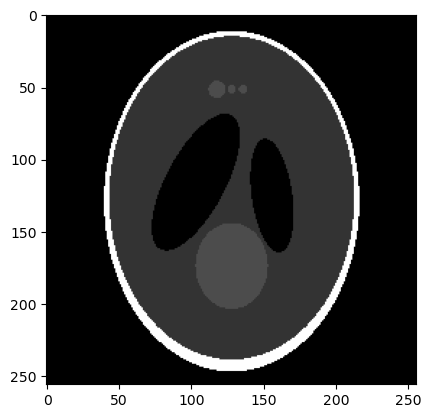

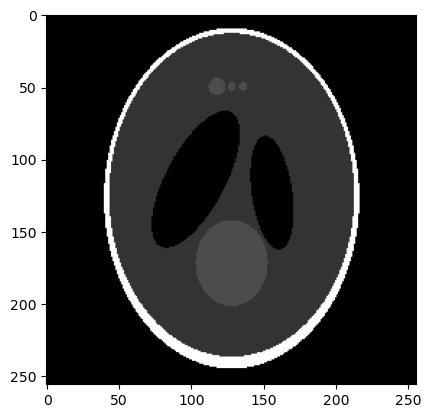

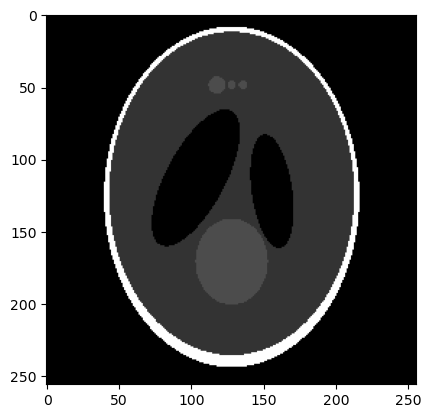

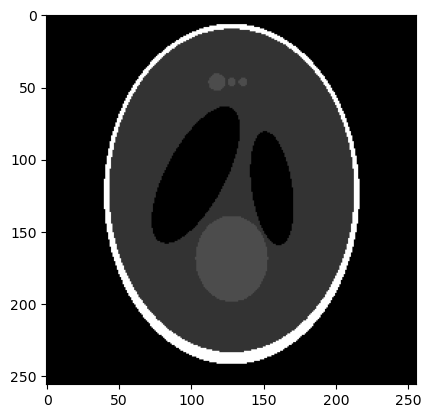

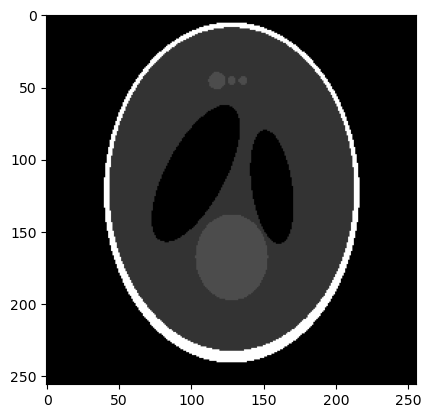

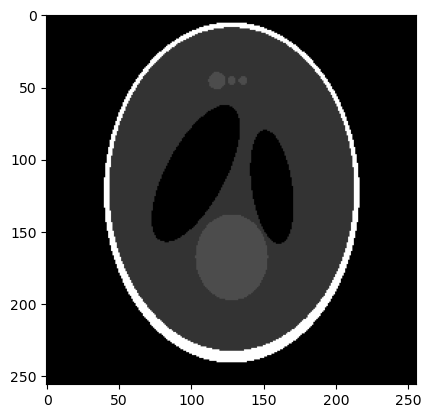

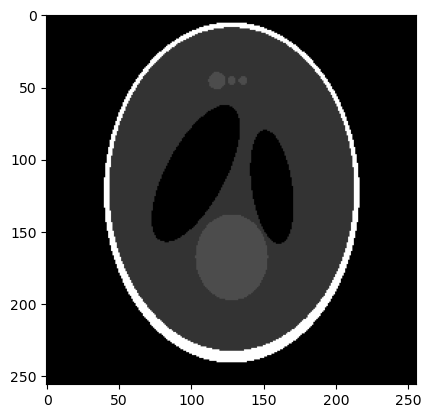

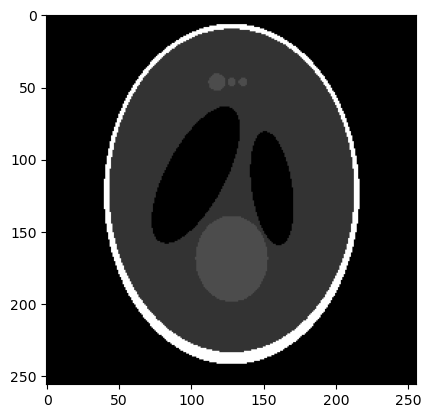

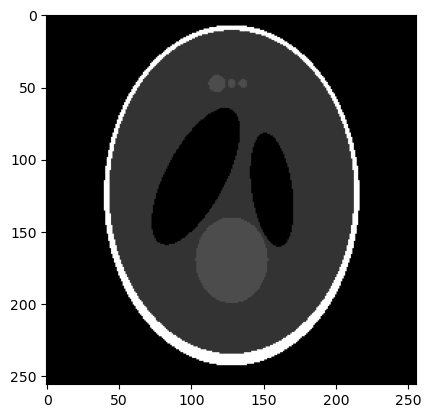

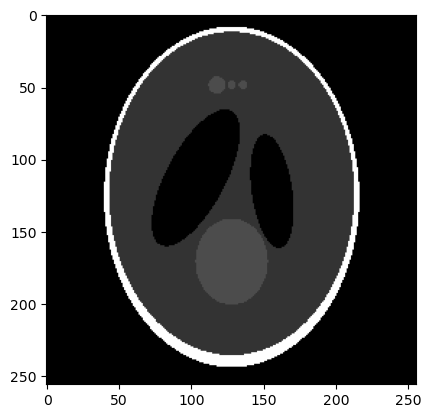

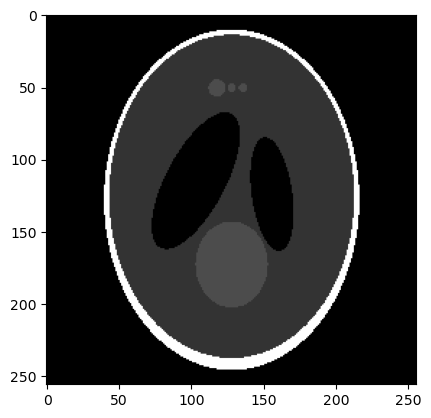

In [35]:
# Create a 3d array along the timescale of a stack of 2D images with shifts characterised by a sinusoidal pattern
num_frames = 20

frequency = 1.0

t = np.linspace(0, 2 * np.pi * frequency, num_frames)

img_stack = np.zeros((256, 256, num_frames)) #20 256*256 images - initialise array
kspace_stack = np.zeros((256, 256, num_frames)) #hard coded, need to fix
kspace_mag_stack = np.zeros((np.shape(shifted_magnitude_spectrum)[0], np.shape(shifted_magnitude_spectrum)[1], num_frames))

original_img = sp.shepp_logan([256,256], float)


for i in range(num_frames):
    shift = np.round(5*np.sin(t[i])).astype(int)
    img_stack[:,:,i] = shift_2d_array(original_img, 0, shift)
    kspace_stack[:,:,i] = np.fft.fftshift(np.fft.fft2(img_stack[:,:,i]))
    kspace_mag_stack[:,:,i] = np.log(np.abs(kspace_stack[:,:,i]) + 1)
    plt.figure()
    plt.imshow(img_stack[:,:,i], cmap='gray')

Filled row 0 with row 0 of frame 0
Filled row 1 with row 1 of frame 1
Filled row 2 with row 2 of frame 2
Filled row 3 with row 3 of frame 3
Filled row 4 with row 4 of frame 4
Filled row 5 with row 5 of frame 5
Filled row 6 with row 6 of frame 6
Filled row 7 with row 7 of frame 7
Filled row 8 with row 8 of frame 8
Filled row 9 with row 9 of frame 9
Filled row 10 with row 10 of frame 10
Filled row 11 with row 11 of frame 11
Filled row 12 with row 12 of frame 12
Filled row 13 with row 13 of frame 13
Filled row 14 with row 14 of frame 14
Filled row 15 with row 15 of frame 15
Filled row 16 with row 16 of frame 16
Filled row 17 with row 17 of frame 17
Filled row 18 with row 18 of frame 18
Filled row 19 with row 19 of frame 19
Filled row 20 with row 20 of frame 0
Filled row 21 with row 21 of frame 1
Filled row 22 with row 22 of frame 2
Filled row 23 with row 23 of frame 3
Filled row 24 with row 24 of frame 4
Filled row 25 with row 25 of frame 5
Filled row 26 with row 26 of frame 6
Filled row 

Text(0.5, 1.0, 'k-sapce as a result of motion')

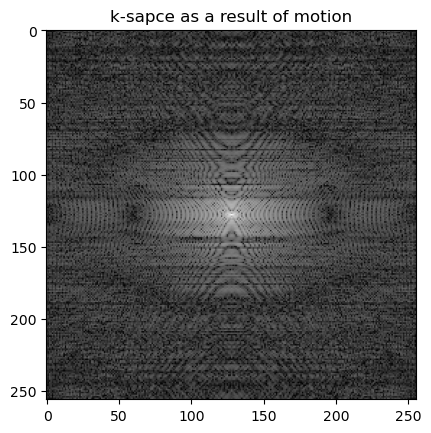

In [38]:
#Sample k-space from stack
sampled_kspace = np.zeros((256,256))

frame_index = 0
for row in range(np.shape(kspace_stack)[0]):
    current_frame = kspace_stack[:,:,frame_index]
    sampled_kspace[row,:] = current_frame[row,:]
    print('Filled row ' + str(row) + ' with row ' + str(row) + ' of frame ' + str(frame_index))
    if row < (num_frames - 1):
        frame_index += 1
    else:
        if (row + 1) % num_frames != 0:
            frame_index += 1
        else:
            frame_index = 0

sampled_kspace_mag = np.log(np.abs(sampled_kspace) + 1)

plt.figure()
plt.imshow(sampled_kspace_mag, cmap='gray')
plt.title('k-sapce as a result of motion')

Text(0.5, 1.0, 'Image with periodic motion artifacts')

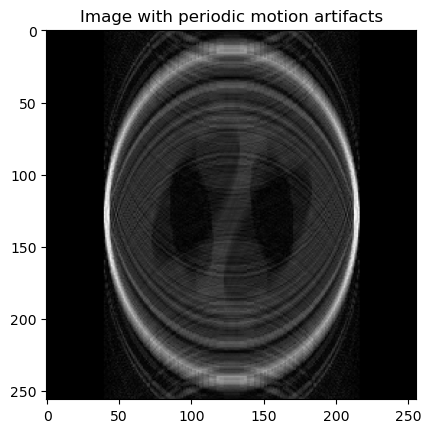

In [37]:
sampled_img = np.fft.ifftn(sampled_kspace)

plt.figure()
plt.imshow(np.abs(sampled_img), cmap='gray')
plt.title('Image with periodic motion artifacts')

### 4. Bloch Simulation